# Кластеризация. Метод K-Means. Домашнее задание

## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Импорт библиотек </h1> 

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from bayes_opt import BayesianOptimization
from sklearn.metrics import make_scorer, silhouette_score


## Задача

Пусть имеется набор данных `Mall_Customers.csv` о покупателях супермаркета:

* CustomerID — идентификатор покупателя;
* Genre — пол;
* Age — возраст;
* Annual Income (k$) — годовой доход покупателя в тыс. долл.;
* Spending Score (1–100) — рейтинг трат покупателя.

Решите задачу кластеризации покупателей, чтобы в дальнейшем планировать маркетинговые акции для каждой группы.

### Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других обнаруженных свойствах данных.

In [4]:
df = pd.read_csv('Mall_Customers.csv')
df.set_index('CustomerID', inplace=True) 
df


,Genre,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


In [5]:
print("Размер датасета:", df.shape)
print("Пропущенные значения:")
print(df.isnull().sum())


Размер датасета: (200, 4)
Пропущенные значения:
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [6]:
df.describe().T.style.background_gradient(cmap='YlOrRd')


,count,mean,std,min,25%,50%,75%,max
Age,200.000000,38.850000,13.969007,18.000000,28.750000,36.000000,49.000000,70.000000
Annual Income (k$),200.000000,60.560000,26.264721,15.000000,41.500000,61.500000,78.000000,137.000000
Spending Score (1-100),200.000000,50.200000,25.823522,1.000000,34.750000,50.000000,73.000000,99.000000


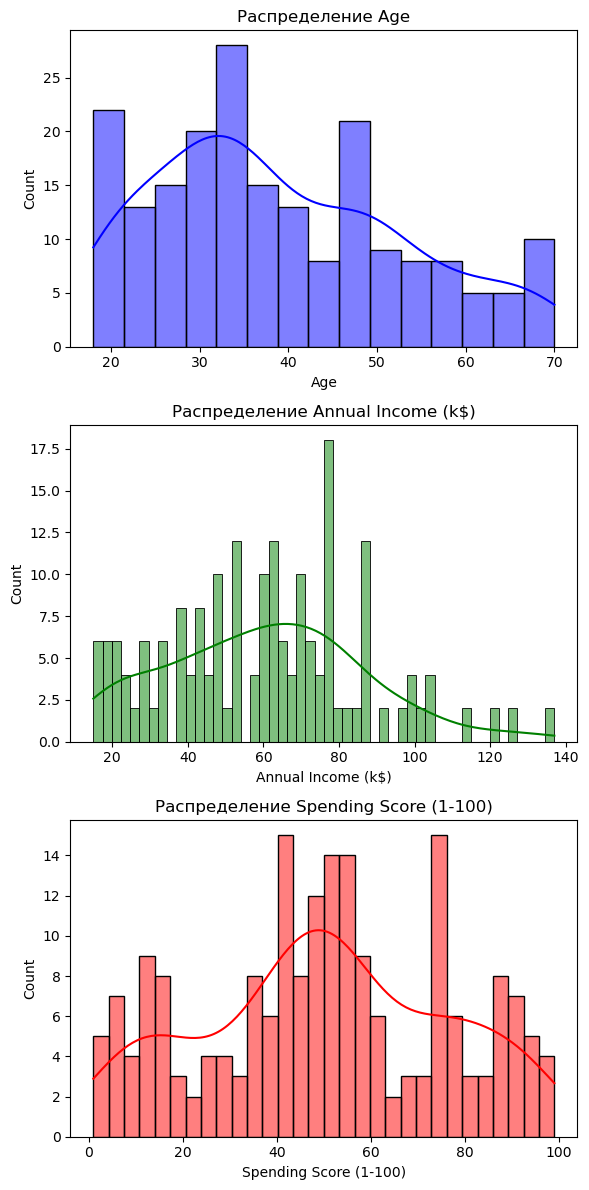

In [7]:
plt.figure(figsize=(6, 12))

plt.subplot(3, 1, 1)  # 3 строки, 1 столбец, 1-й график
sns.histplot(df['Age'], bins=15, kde=True, color='blue')
plt.title('Распределение Age')

plt.subplot(3, 1, 2)  # 3 строки, 1 столбец, 2-й график
sns.histplot(df['Annual Income (k$)'], bins=50, kde=True, color='green')
plt.title('Распределение Annual Income (k$)')

plt.subplot(3, 1, 3)  # 3 строки, 1 столбец, 3-й график
sns.histplot(df['Spending Score (1-100)'], bins=30, kde=True, color='red')
plt.title('Распределение Spending Score (1-100)')

plt.tight_layout()  # Чтобы графики не накладывались друг на друга
plt.show()


Text(0.5, 1.0, 'Распределение Genre')

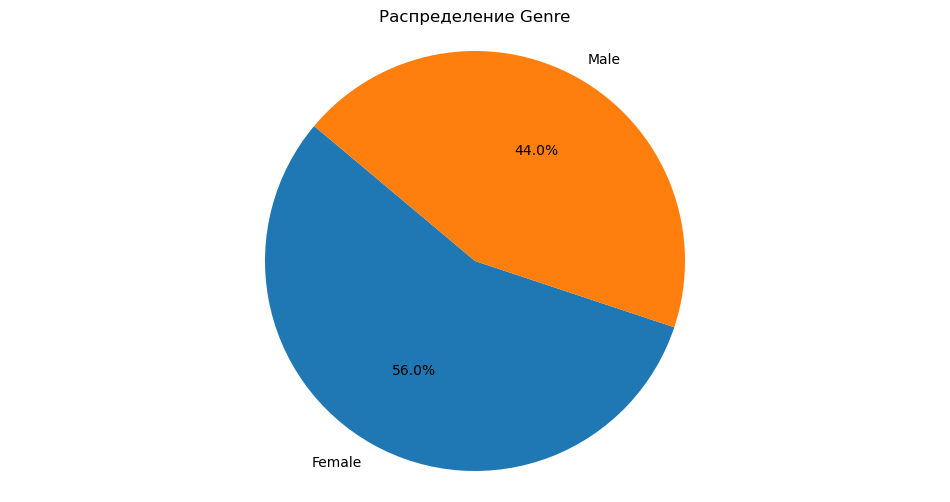

In [8]:
plt.figure(figsize=(12, 6))

genre_counts = df['Genre'].value_counts()
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.title('Распределение Genre')


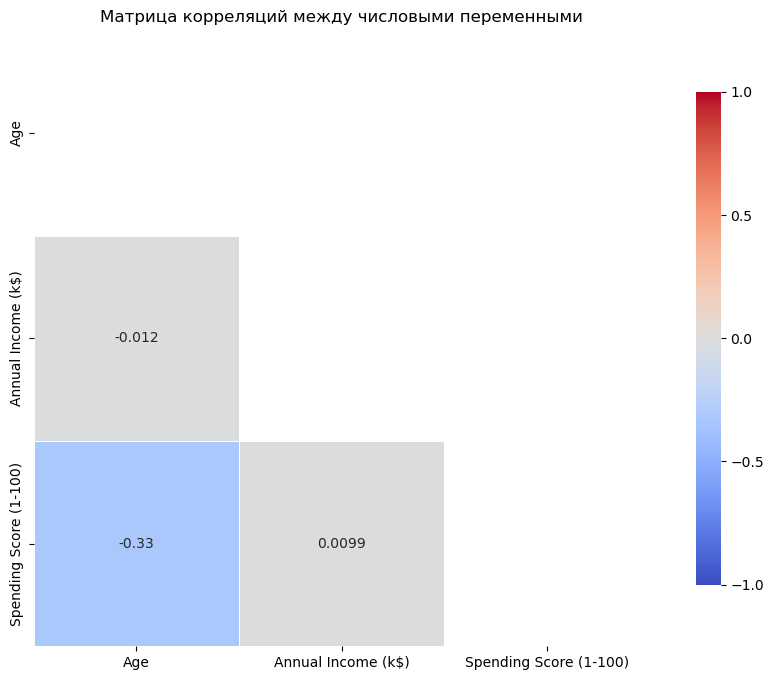

In [16]:
df_cor = df.select_dtypes(include=['number']).copy()
correlation_matrix = df_cor.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0, 
            square=True, linewidths=.5, annot_kws={"size": 10}, 
            cbar_kws={"shrink": 0.8, "orientation": "vertical", "ticks": [-1, -0.5, 0, 0.5, 1]})
plt.title('Матрица корреляций между числовыми переменными')
plt.show()


### Задание 2

Метод k-средних требует явно задать количество кластеров, на которые будут разбиваться данные. Поскольку данных может быть настолько много, что построение одной модели будет занимать несколько часов, важно примерно оценить количество кластеров до запуска обучения модели.

На основе результатов разведочного анализа данных предположите, какое количество кластеров будет оптимальным, и аргументируйте предположение.

**Предполагаю, что оптимальное количество кластеров - 3, это можно предположить по гистограмам распределния числовых признаков, которые делятся на левую, центральную и вытянутую правую части.**

### Задание 3

Преобразуйте категориальный признак Genre в численный.

In [19]:
df = pd.get_dummies(df, columns=['Genre'], drop_first=True)
df


,Age,Annual Income (k$),Spending Score (1-100),Genre_Male
CustomerID,,,,
1,19,15,39,True
2,21,15,81,True
3,20,16,6,False
4,23,16,77,False
5,31,17,40,False
...,...,...,...,...
196,35,120,79,False
197,45,126,28,False
198,32,126,74,True


### Задание 4

Постройте модель кластеризации с помощью метода k-средних. Определите оптимальное количество кластеров с помощью метода локтя.

c:\Users\Norge\anaconda3\envs\data_parsing\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Norge\anaconda3\envs\data_parsing\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Norge\anaconda3\envs\data_parsing\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Norge\anaconda3\envs\data_parsing\lib\site-packages\sklearn\cluster\_kmea

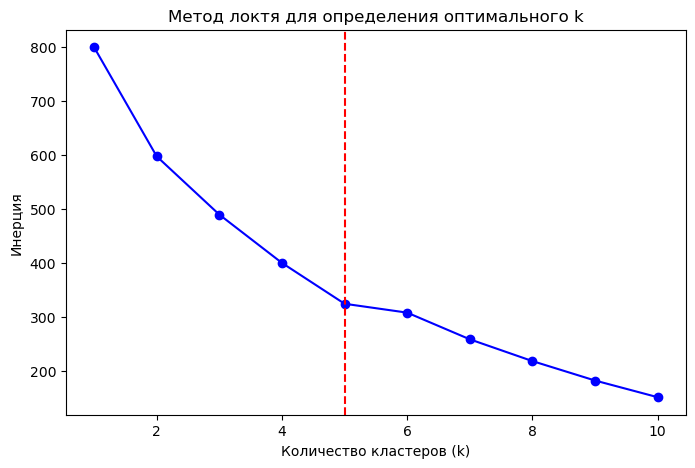

In [29]:
X = df.copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
k_range = range(1, 11)  

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, 'bo-')
plt.axvline(x=5, color='red', linestyle='--', label='Оптимальное k = 5')  # Добавляем вертикальную линию
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция')
plt.title('Метод локтя для определения оптимального k')
plt.show()


### Задание 5

Постройте финальную модель кластеризации с количеством кластеров, опредёленным в предыдущем задании.

c:\Users\Norge\anaconda3\envs\data_parsing\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Norge\AppData\Local\Temp\ipykernel_1364\3159829268.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


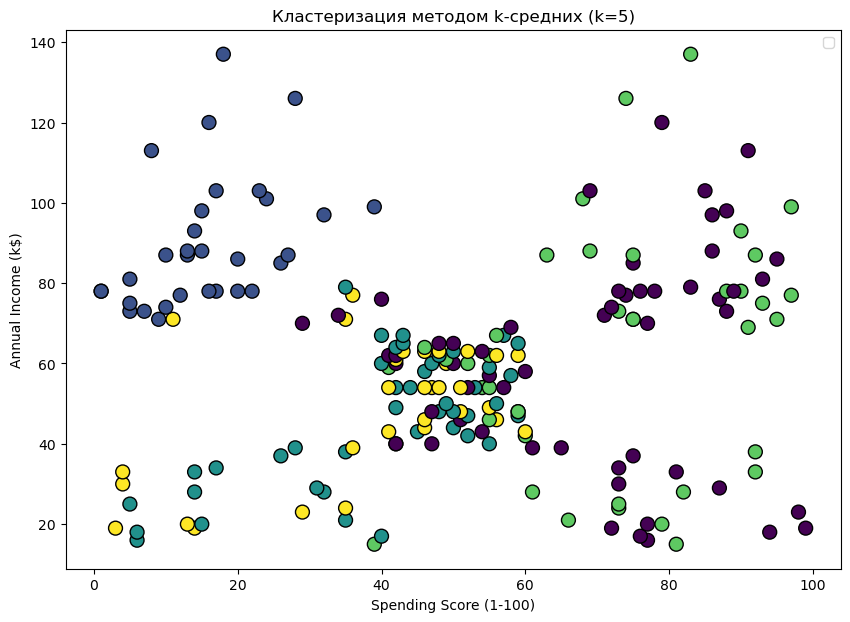

C:\Users\Norge\AppData\Local\Temp\ipykernel_1364\3159829268.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


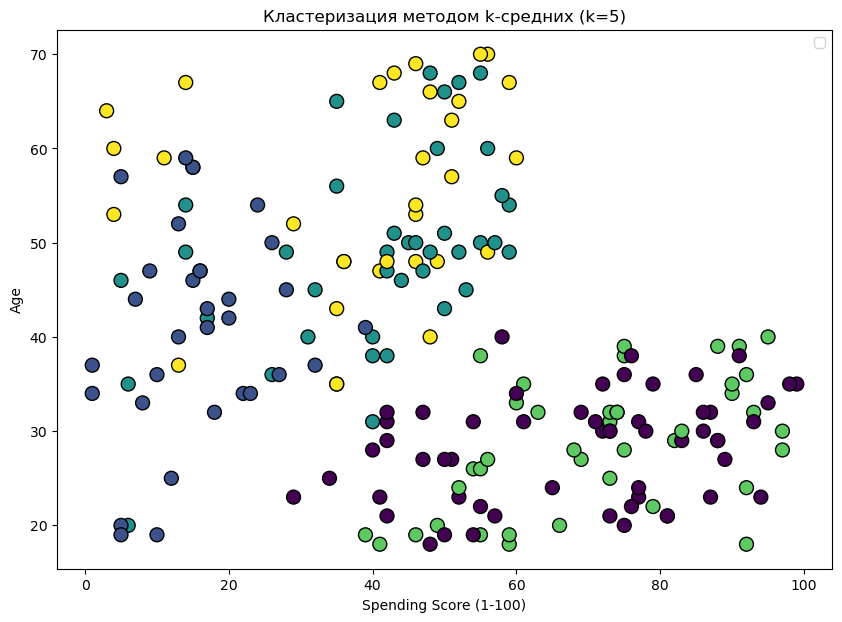

In [40]:
k = 5

kmeans = KMeans(n_clusters=k, random_state=1)
clusters = kmeans.fit_predict(X_scaled)  # Применяем кластеризацию к масштабированным данным
df['Cluster'] = clusters

plt.figure(figsize=(10, 7))
plt.scatter(df['Spending Score (1-100)'], df['Annual Income (k$)'], c=df['Cluster'], cmap='viridis', s=100, marker='o', edgecolor='k')
plt.xlabel('Spending Score (1-100)')
plt.ylabel('Annual Income (k$)')
plt.title('Кластеризация методом k-средних (k=5)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
plt.scatter(df['Spending Score (1-100)'], df['Age'], c=df['Cluster'], cmap='viridis', s=100, marker='o', edgecolor='k')
plt.xlabel('Spending Score (1-100)')
plt.ylabel('Age')
plt.title('Кластеризация методом k-средних (k=5)')
plt.legend()
plt.show()


# Кластеризация. DBSCAN

Имеется некоторый набор данных `gt_2015.csv` о производительности и других параметрах ветряных электростанций:
* AT — температура окружающей среды.
* PT — давление окружающей среды.
* AH — влажность окружающей среды.
* AFDP — перепад давления на воздушном фильтре.
* GTEP — давление на выходе из газовой турбины.
* TIT — температура на входе в турбину.
* TAT — температура на выходе из турбины.
* TEY — энергоотдача турбины.
* CDP — давление нагнетания компрессора.
* CO — выбросы угарного газа.
* NOX — выбросы оксидов азота.

Решите задачу кластеризации электростанций для дальнейшего совместного управления схожими электростанциями.

# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

In [2]:
df = pd.read_csv('gt_2015.csv')
df


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515
...,...,...,...,...,...,...,...,...,...,...,...
7379,3.62680,1028.5,93.200,3.1661,19.087,1037.0,541.59,109.08,10.411,10.9930,89.172
7380,4.16740,1028.6,94.036,3.1923,19.016,1037.6,542.28,108.79,10.344,11.1440,88.849
7381,5.48200,1028.5,95.219,3.3128,18.857,1038.0,543.48,107.81,10.462,11.4140,96.147
7382,5.88370,1028.7,94.200,3.9831,23.563,1076.9,550.11,131.41,11.771,3.3134,64.738


In [3]:
print("Размер датасета:", df.shape)
print("Пропущенные значения:")
print(df.isnull().sum())


Размер датасета: (7384, 11)
Пропущенные значения:
AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64


In [6]:
df.describe().T.style.background_gradient(cmap='YlOrRd')


,count,mean,std,min,25%,50%,75%,max
AT,7384.000000,17.225259,8.095783,-6.234800,11.073250,17.456500,23.684750,37.103000
AP,7384.000000,1014.509110,6.895430,989.400000,1009.675000,1014.000000,1018.300000,1036.600000
AH,7384.000000,68.647464,13.541116,24.085000,59.447250,70.952000,79.653750,96.666000
AFDP,7384.000000,3.598909,0.610226,2.368800,3.117300,3.538500,4.194825,5.239500
GTEP,7384.000000,26.130149,4.473737,17.698000,23.147000,25.331000,30.018250,40.716000
TIT,7384.000000,1078.974689,19.762449,1016.000000,1070.500000,1080.300000,1099.900000,1100.400000
TAT,7384.000000,546.642484,5.489066,516.040000,544.747500,549.720000,550.030000,550.590000
TEY,7384.000000,133.993380,16.179208,100.020000,126.255000,131.600000,147.160000,179.500000
CDP,7384.000000,12.097025,1.136601,9.870800,11.465750,11.933000,13.148000,15.159000
CO,7384.000000,3.129986,2.234962,0.212800,1.808175,2.533400,3.702550,41.097000


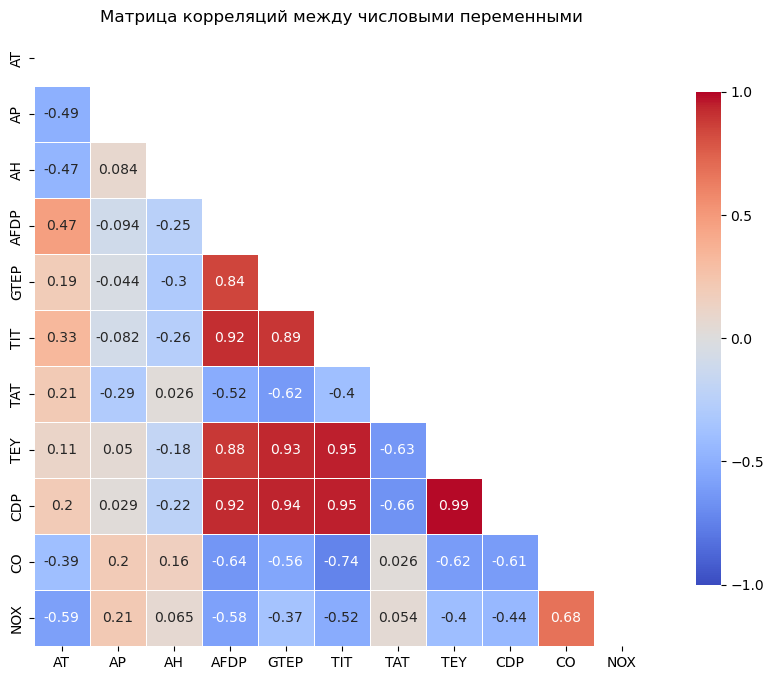

In [7]:
df_cor = df.select_dtypes(include=['number']).copy()
correlation_matrix = df_cor.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0, 
            square=True, linewidths=.5, annot_kws={"size": 10}, 
            cbar_kws={"shrink": 0.8, "orientation": "vertical", "ticks": [-1, -0.5, 0, 0.5, 1]})
plt.title('Матрица корреляций между числовыми переменными')
plt.show()


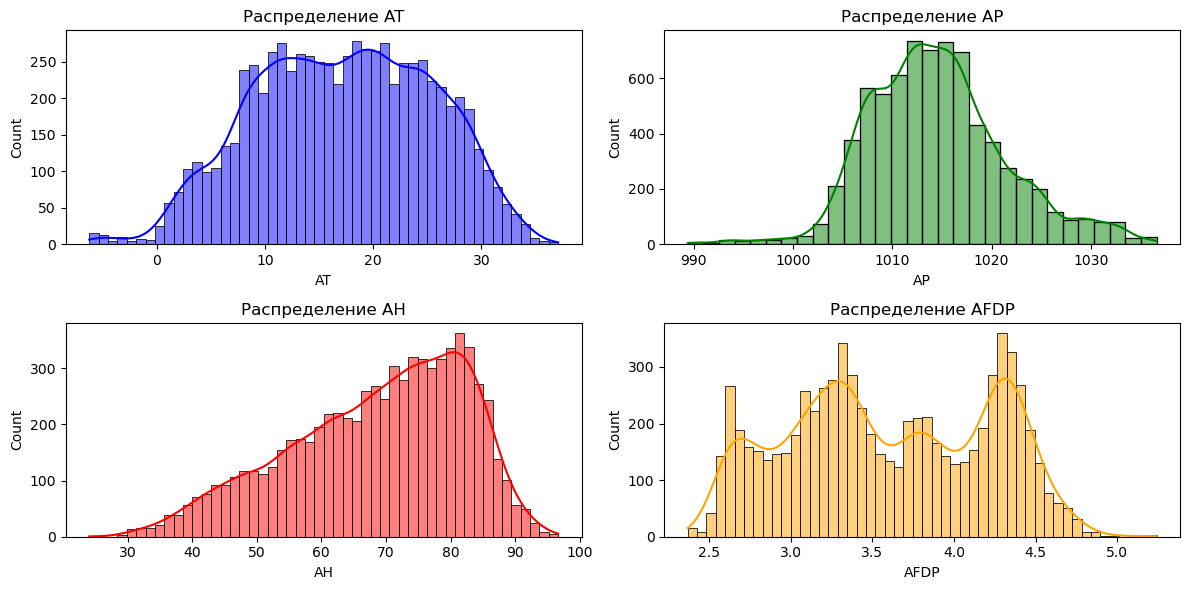

In [9]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(df['AT'], bins=50, kde=True, color='blue')
plt.title('Распределение AT')

plt.subplot(2, 2, 2)
sns.histplot(df['AP'], bins=30, kde=True, color='green')
plt.title('Распределение AP')

plt.subplot(2, 2, 3)
sns.histplot(df['AH'], bins=50, kde=True, color='red')
plt.title('Распределение AH')

plt.subplot(2, 2, 4)
sns.histplot(df['AFDP'], bins=50, kde=True, color='orange')
plt.title('Распределение AFDP')

plt.tight_layout()
plt.show()


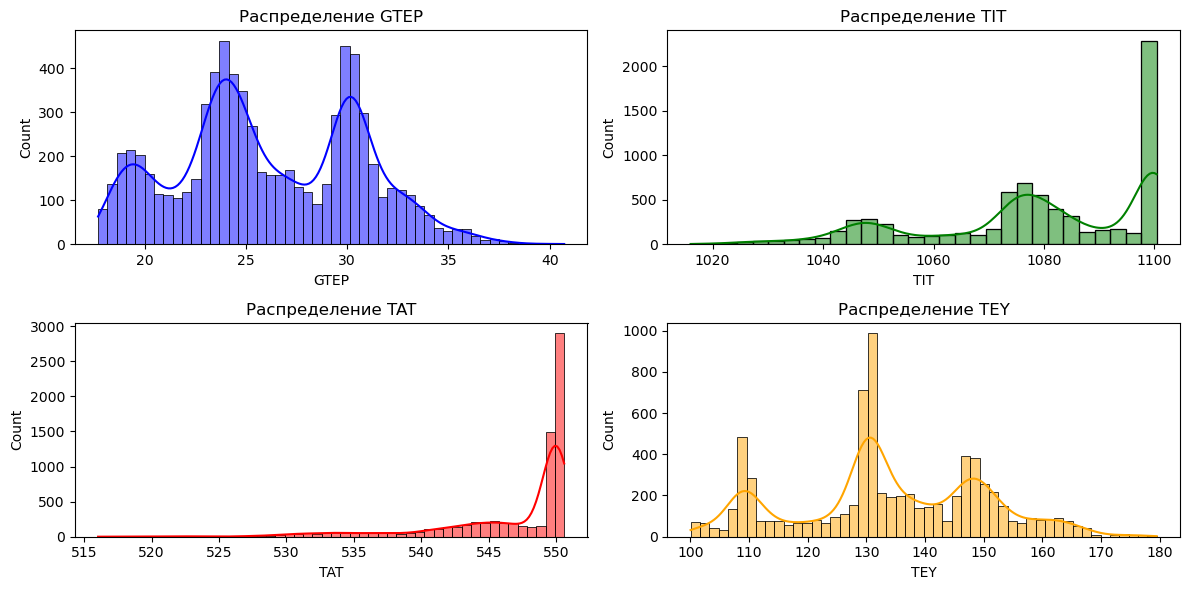

In [11]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(df['GTEP'], bins=50, kde=True, color='blue')
plt.title('Распределение GTEP')

plt.subplot(2, 2, 2)
sns.histplot(df['TIT'], bins=30, kde=True, color='green')
plt.title('Распределение TIT')

plt.subplot(2, 2, 3)
sns.histplot(df['TAT'], bins=50, kde=True, color='red')
plt.title('Распределение TAT')

plt.subplot(2, 2, 4)
sns.histplot(df['TEY'], bins=50, kde=True, color='orange')
plt.title('Распределение TEY')

plt.tight_layout()
plt.show()


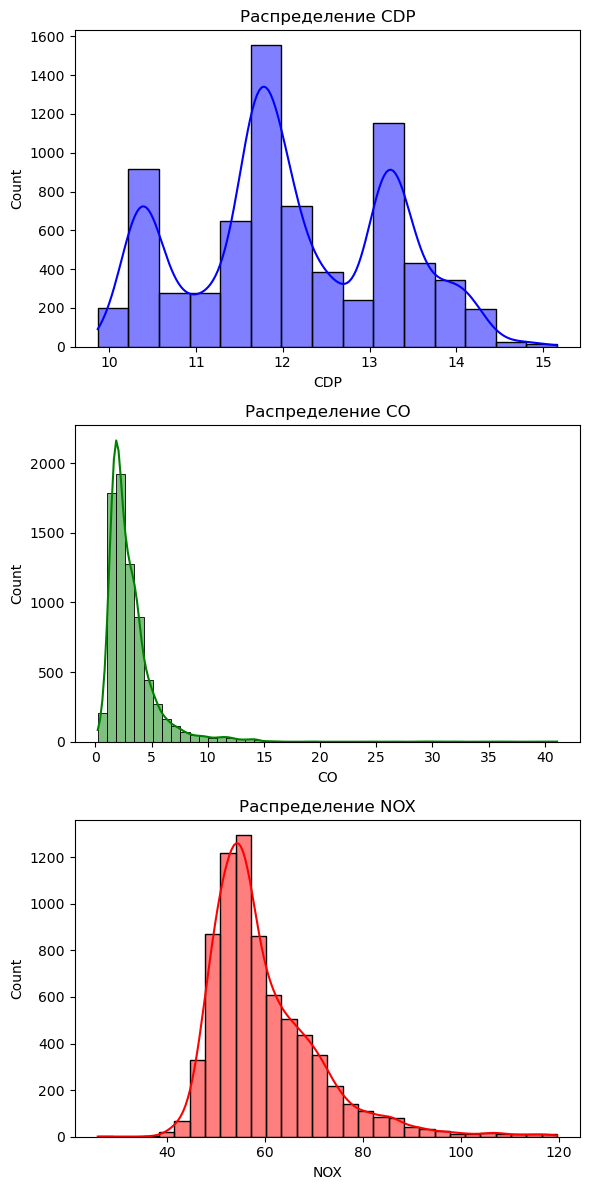

In [14]:
plt.figure(figsize=(6, 12))

plt.subplot(3, 1, 1)  # 3 строки, 1 столбец, 1-й график
sns.histplot(df['CDP'], bins=15, kde=True, color='blue')
plt.title('Распределение CDP')

plt.subplot(3, 1, 2)  # 3 строки, 1 столбец, 2-й график
sns.histplot(df['CO'], bins=50, kde=True, color='green')
plt.title('Распределение CO')

plt.subplot(3, 1, 3)  # 3 строки, 1 столбец, 3-й график
sns.histplot(df['NOX'], bins=30, kde=True, color='red')
plt.title('Распределение NOX')

plt.tight_layout() 
plt.show()


# Задание 2

Предположите по результатам разведочного анализа данных, какие группы электростанций существуют, чем они отличаются, каково их количество.

**Можно предположить, что электростанций 4 группы, так как на некоторых гистограммах распределния отображено такое количество пиков.**

# Задание 3

Постройте модель кластеризации DBSCAN. Подберите оптимальные гиперпараметры, руководствуясь как результатами сеточного поиска, так и результатами анализа данных в предыдущих заданиях.

In [30]:
X = df.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [31]:
def dbscan_clustering(eps, min_samples):
    # Инициализация модели DBSCAN с параметрами из баейсовского оптимизатора
    dbscan = DBSCAN(eps=eps, min_samples=int(min_samples))
    
    # Выполняем кластеризацию
    labels = dbscan.fit_predict(X_scaled)
    
    # Если больше двух кластеров, считаем силуэтный коэффициент
    if len(set(labels)) > 2:
        score = silhouette_score(X_scaled, labels)
    else:
        score = -1  # Возвращаем низкий результат, если меньше двух кластеров
    
    return score

pbounds = {
    'eps': (0.1, 1.5),  # Радиус окрестности
    'min_samples': (3, 10)  # Минимальное количество точек в кластере
}

optimizer = BayesianOptimization(
    f=dbscan_clustering,  # Функция для оптимизации
    pbounds=pbounds,  # Диапазоны гиперпараметров
    random_state=1
)

optimizer.maximize(
    init_points=10,  # Количество случайных запусков перед началом баейсовского процесса
    n_iter=32  # Количество итераций оптимизации
)

print(f"Лучшие параметры: {optimizer.max}")


|   iter    |  target   |    eps    | min_sa... |
-------------------------------------------------
| 1         | -0.3405   | 0.6838    | 8.042     |
| 2         | -1.0      | 0.1002    | 5.116     |
| 3         | -0.3598   | 0.3055    | 3.646     |
| 4         | -0.3971   | 0.3608    | 5.419     |
| 5         | -0.354    | 0.6555    | 6.772     |
| 6         | -0.3471   | 0.6869    | 7.797     |
| 7         | -0.4752   | 0.3862    | 9.147     |
| 8         | -1.0      | 0.1383    | 7.693     |
| 9         | -0.3546   | 0.6842    | 6.911     |
| 10        | -0.4525   | 0.2965    | 4.387     |
| 11        | -0.0867   | 1.006     | 7.917     |
| 12        | -0.0882   | 1.018     | 7.929     |
| 13        | 0.1728    | 1.314     | 7.565     |
| 14        | 0.6034    | 1.5       | 7.132     |
| 15        | 0.5918    | 1.5       | 6.635     |
| 16        | 0.5918    | 1.5       | 5.725     |
| 17        | 0.5918    | 1.5       | 4.874     |
| 18        | 0.5904    | 1.5       | 3.941     |


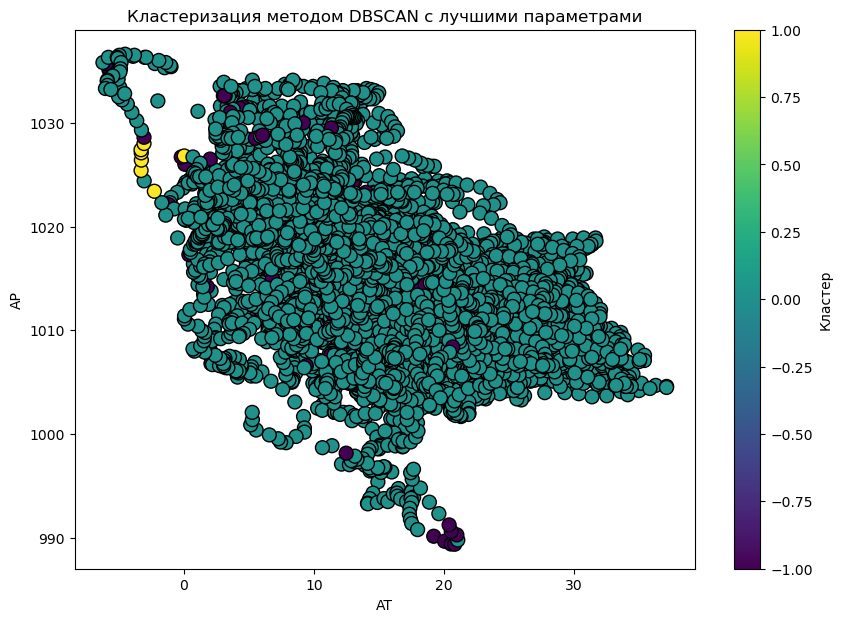

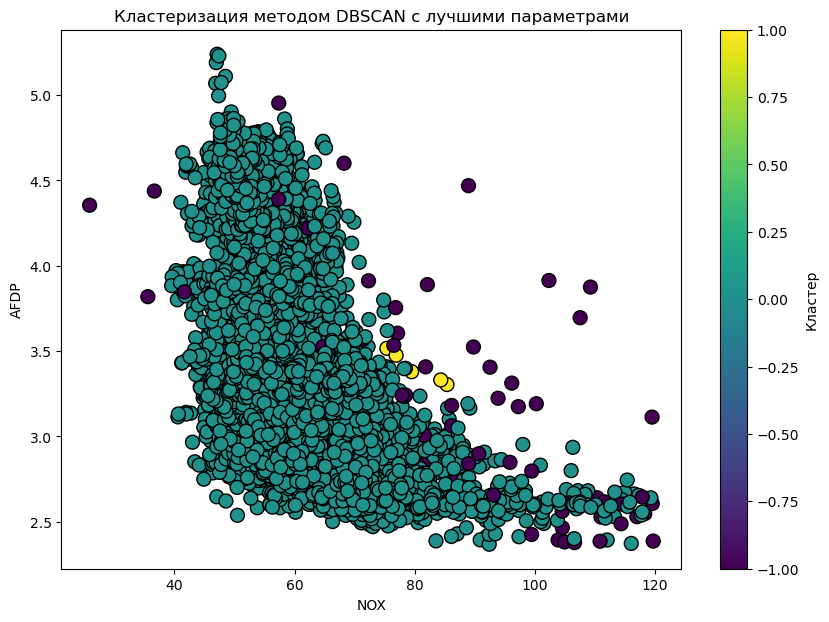

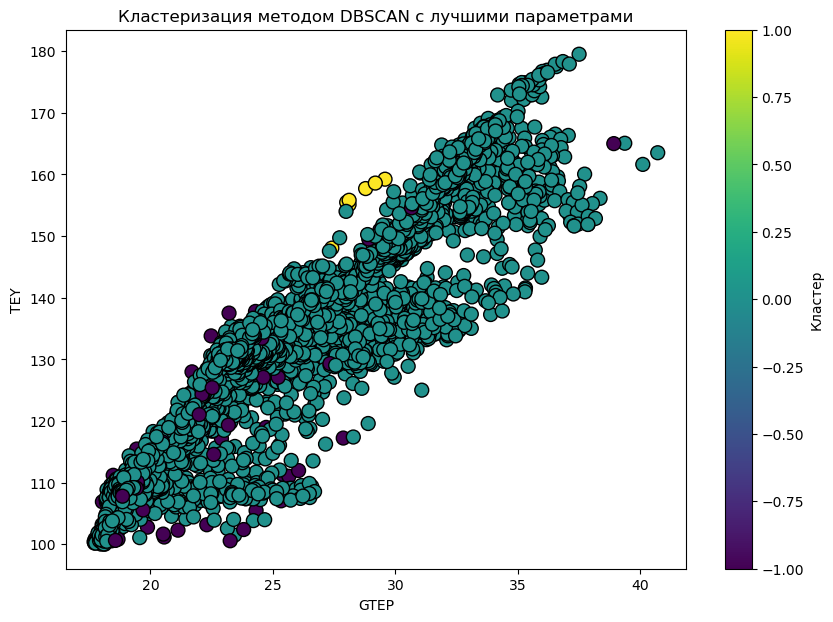

In [32]:
best_params = optimizer.max['params']
best_eps = best_params['eps']
best_min_samples = int(best_params['min_samples'])  # Преобразуем в int

dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels = dbscan_best.fit_predict(X_scaled)

df['Cluster'] = labels

plt.figure(figsize=(10, 7))
plt.scatter(df['AT'], df['AP'], c=df['Cluster'], cmap='viridis', s=100, marker='o', edgecolor='k')
plt.xlabel('AT')
plt.ylabel('AP')
plt.title('Кластеризация методом DBSCAN с лучшими параметрами')
plt.colorbar(label='Кластер')
plt.show()

plt.figure(figsize=(10, 7))
plt.scatter(df['NOX'], df['AFDP'], c=df['Cluster'], cmap='viridis', s=100, marker='o', edgecolor='k')
plt.xlabel('NOX')
plt.ylabel('AFDP')
plt.title('Кластеризация методом DBSCAN с лучшими параметрами')
plt.colorbar(label='Кластер')
plt.show()

plt.figure(figsize=(10, 7))
plt.scatter(df['GTEP'], df['TEY'], c=df['Cluster'], cmap='viridis', s=100, marker='o', edgecolor='k')
plt.xlabel('GTEP')
plt.ylabel('TEY')
plt.title('Кластеризация методом DBSCAN с лучшими параметрами')
plt.colorbar(label='Кластер')
plt.show()


# Задание 4

Интерпретируйте результаты кластеризации: объясните, чем схожи электростанции в каждом кластере и чем аномальные электростанции отличаются от остальных.

**Кластеризация на данных не дела хорошего результата, т.к. точки расположены достаточно густо в признаковом пространстве.**